# Train model with Pine taget notes

In [14]:
import warnings
import torch

from gflownet.config import init_empty, Config
from rdkit.Chem.Draw import MolsToGridImage
import pathlib

from molecule import MoleculeTrainer

import pandas as pd
import random
import datetime

In [15]:
from fragments import FRAGMENTS
import json

In [16]:
keys = pd.read_csv('data.csv').keys()

In [17]:
with open('pine_target.json', 'r') as file:
    target = json.load(file)

df = pd.DataFrame(columns=keys)
df.loc[0] = ['CC','']+ target
df

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC,,0.097679,0.340419,0.135374,0.143439,0.545764,0.435706,0.303856,0.230499,...,0.416362,0.103733,0.34375,0.350655,0.36543,0.30633,0.242954,0.24685,0.121464,0.911624


In [18]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')


# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = f"Pine_{datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')}"
config.device = dev
config.num_training_steps = 500
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 100
config.algo.max_nodes = 6 #12 # 95 quantil
config.store_all_checkpoints = True

trial = MoleculeTrainer(config,dataframe=df,fragments=FRAGMENTS, print_config=True)



Hyperparameters:

desc: noDesc
log_dir: Pine_2024-12-02__14_14_21
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 100
store_all_checkpoints: true
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 500
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 6
  max_edges: 128
  illegal_action_logreward: -1.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_decay: 50000

In [19]:
trial.run()

02/12/2024 14:14:23 - INFO - logger - Starting training


KeyboardInterrupt: 

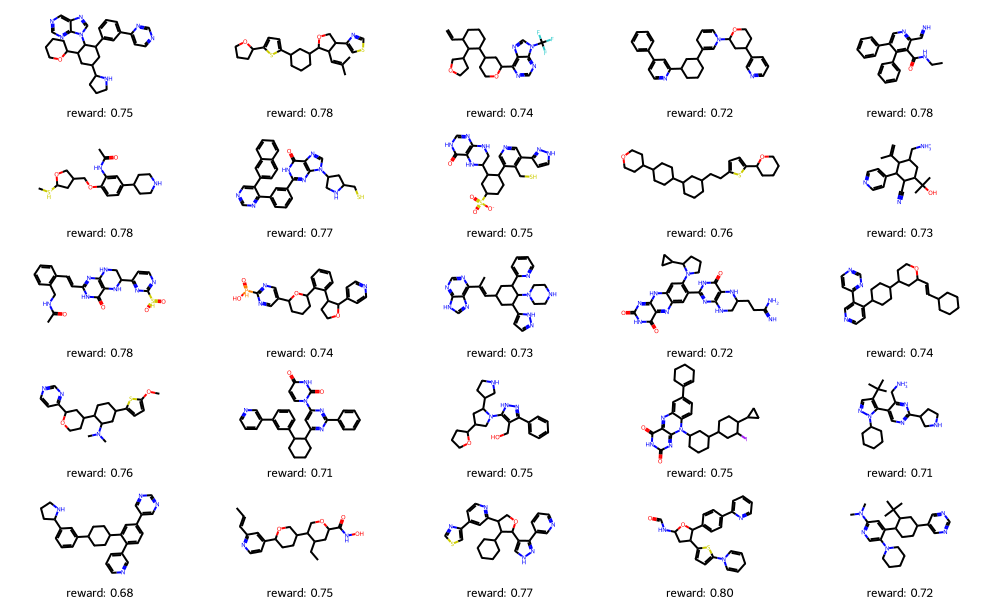

In [7]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(-1)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])

In [8]:
from rdkit import Chem
smileslst= []
for i in objs:
    smiles = Chem.MolToSmiles(i)
    smileslst.append(smiles)
smileslst

['c1cc(-c2ccncn2)cc(C2CC(C3CCCN3)CC(C3CCCCO3)C2n2cnc3cncnc32)c1',
 'CC(C)=CC1C(c2cscn2)COC1C1CCCC(c2ccc(C3CCCO3)s2)C1',
 'C=CC1CCCC(C2CCOC(c3ncnc4c3ncn4C(F)(F)F)C2)C1C1CCOC1',
 'C1=CN(C2CC(c3cccnc3)CCO2)C=C(C2CCCC(c3cc(-c4ccccc4)ccn3)C2)C1',
 'CCNC(=O)c1c(C=N)ncc(-c2ccccc2)c1-c1ccccc1',
 'C[SH+]C1CC(COc2ccc(C3CCNCC3)cc2NC(C)=O)CO1',
 'O=c1[nH]c(-c2cccc(-c3ncncc3-c3ccc4ccccc4c3)c2)nc2c1ncn2C1CNC(CS)C1',
 'O=c1[nH]cnc2c1NC(C1CC(S(=O)(=O)[O-])CCC1c1cncc(-c3cc[nH]n3)c1CS)CN2',
 'c1cc(C2CCCCO2)sc1CCC1CCCC(C2CCC(C3CCOCC3)CC2)C1',
 'C=C(C)C1C(C[NH3+])CC(C(C)(C)O)C(C#N)C1c1ccncc1',
 'CC(=O)NCc1ccccc1C=Cc1nc2c(c(=O)[nH]1)NC(c1ccnc([SH](=O)=O)n1)CN2',
 'O=[PH](O)c1ncc(C2CCCC(c3ccccc3C3CCOC3c3ccncc3)O2)cn1',
 'CC(=CC1CC(c2ccccn2)C(N2CCNCC2)C(c2ccn[nH]2)C1)c1ncnc2[nH]cnc12',
 'N=C(N)CCC1CNc2nc(-c3cc4nc5c(=O)[nH]c(=O)nc-5[nH]c4cc3N3CCCC3C3CC3)[nH]c(=O)c2N1',
 'C(=CC1CC(C2CCC(c3ccncc3-c3ccncn3)CC2)CCO1)C1CCCCC1',
 'COc1ccc(C2CCC(C3CCOC(c4ccncn4)C3)C(N(C)C)C2)s1',
 'O=c1ccn(-c2cc(C3CCCCC3c3cccc(-c4cc

In [9]:
smileslst=['FC(F)(F)c1ccc(-c2ccncn2)cc1C1CCC(C2CCCCC2)CC1C1CCCO1',
 'CC(C)(O)c1ncnc2c1ncn2-c1ncncc1-c1ncccc1-n1nccc1-c1ccccc1',
 'CC(=Cc1nc2c(c(=O)[nH]1)NC(c1ncccc1-c1cc([N+](=O)[O-])cc3ccccc13)CN2)c1ccccc1',
 'O=c1nc2[nH]c3ccc(-c4nc5c(c(=O)[nH]4)NC(C4CC(N6CCOCC6)OC4c4ccncc4-c4ccccc4)CN5)cc3nc-2c(=O)[nH]1',
 'O=c1nc(-c2ccn(-c3cccs3)n2)ccn1C1=CC(c2n[nH]cc2S(=O)(=O)O)CCC1',
 'N=C(N)c1c(-c2ccccc2C2CCNCC2)cc(S(=O)(=O)[O-])nc1N1CCCCC1',
 'c1ccc(-c2ncnc(C3CCCN3)c2-c2ccc(C3CCCOC3c3ccncc3)cc2)cc1',
 'NCC1CCN(C2CCC(N3CCCC3)O2)CC1C1CCOCC1c1ccc2[nH]c3nc(=O)[nH]c(=O)c-3nc2c1',
 'O=c1[nH]c(C2CCC(c3nccc(N4CCCC4)c3C3CCOC3)CC2)nc2c1NC(F)CN2',
 'CC(C)(C)OCc1c(-c2nc3[nH]cnc3c(=O)[nH]2)cc(C2CC=CCC2)nc1N1CCCCC1',
 'C(=CC1OCCC1C1CCOC1)C1CCCC(c2ccccc2-c2cccnc2)O1',
 'O=S(=O)([O-])NCc1ccc(N2C=CCC(c3ccccc3-c3ccccc3)=C2)cc1',
 'N=Cc1c(C2CCC(C3CCOC3)CC2c2ccccc2)cnn1-c1ccccc1',
 'CN(C)C1CCNCC1c1ccc(-c2nc3c(c(=O)[nH]2)NC(c2ccncn2)CN3)nc1-c1cccnc1',
 'O=CNCc1nc(C2CCCC(C3CCOC3)C2C2CCC(N3CCCC3)N2)cs1',
 'NCC1CC(N2CCC(C3C=CCCC3)C2)CC(c2ccccc2C2CCCC2)O1',
 'O=c1nc2n(C3CC(c4ccccn4)CCC3P(=O)([O-])O)c3cc(C4CCCOC4)c(CS)cc3nc-2c(=O)[nH]1',
 'c1ccc2cc(-c3ccncc3C3CCCCC3c3cnc(C4CCCOC4)nc3C3CCCOC3)ccc2c1',
 'CC(=O)c1ccc(-c2cccc(N3CCC(C4CCCCC4)CC3)c2)cc1C1CCNC1',
 'O=c1nc2n(-n3cc(C4CCCC(c5ccc(-c6cncnc6C6CCCN6)nc5)C4)c(=O)[nH]c3=O)c3ccccc3nc-2c(=O)[nH]1',
 'O=C([O-])c1c(N2CCNCC2)ncnc1-n1c2nc(=O)[nH]c(=O)c-2nc2cc(C3CCCCC3)c(-[n+]3ccccc3)cc21',
 'O=c1nc2[nH]c3ccc(C4OCCCC4c4ccc(-c5ccc(C6CCCO6)c(C6CNc7nc[nH]c(=O)c7N6)c5)cc4)cc3nc-2c(=O)[nH]1',
 'C1=CN(c2cc(C3COCC(N4CCOCC4)C3c3ccc[nH+]c3)ccc2-c2cccnc2)C=CC1',
 'c1ccc(C2C(COc3ccccn3)CCCC2c2cccc(-c3ccn[nH]3)c2)cc1',
 'C=C(C)c1c(N2CCC(C3CCC(c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)CC3)CC2)ccnc1CC']

In [10]:
from rdkit import Chem

In [11]:
rewards = []
for i in smileslst:
    rew = trial.task.reward_function(Chem.MolFromSmiles(i))
    rewards.append(rew)
rewards

[0.724683,
 0.7516391,
 0.6856914,
 0.7527662,
 0.7639743,
 0.7869765,
 0.6733772,
 0.7422758,
 0.73581105,
 0.7370157,
 0.67147124,
 0.8301386,
 0.7388325,
 0.74053663,
 0.7493274,
 0.7347254,
 0.7674694,
 0.67176706,
 0.6771194,
 0.7552957,
 0.75252277,
 0.74655807,
 0.7268297,
 0.65614647,
 0.74036354]

In [12]:
pen = []
for i in smileslst:
    p = trial.task.is_valid_molecule(Chem.MolFromSmiles(i))
    pen.append(p)
pen

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

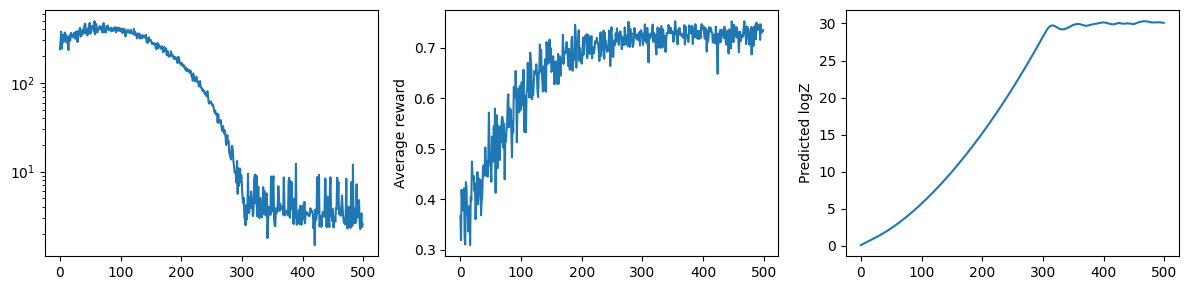

In [13]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()